Saved transformed FACS→microscopy data to /Users/simonvanvliet/Library/CloudStorage/Dropbox/Work/Code/Spatial Tolerance Model/2DModel/0_calibration_curves_hqno/hqno_facs_transformed.csv


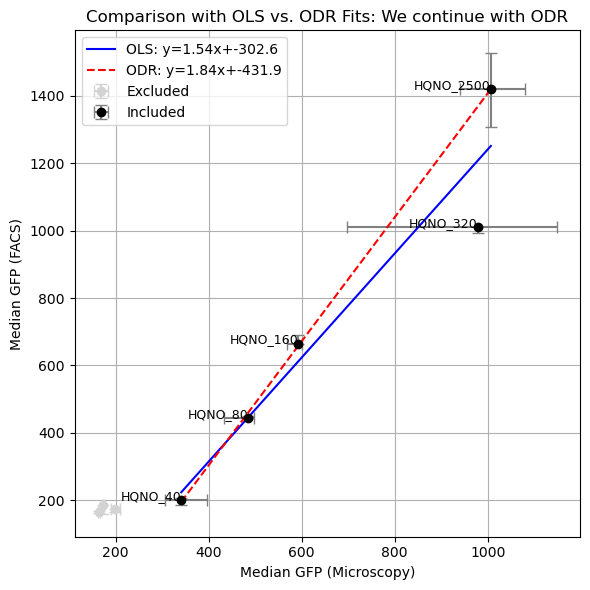

In [5]:
import json
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.odr import Model, RealData, ODR

from pathlib import Path

data_folder = Path.cwd().parents[1] / 'datafiles'

# ——— Configuration ———
FACS_CSV    = data_folder / 'hqno_calibration_facs.csv'
MICRO_CSV   = data_folder / 'hqno_calibration_microscopy.csv'

HQNO_ORDER  = [
    'HQNO_0','HQNO_5','HQNO_10','HQNO_20','HQNO_40','HQNO_80',
    'HQNO_160','HQNO_320','HQNO_640','HQNO_1280','HQNO_2500','HQNO_5000'
]
COMPARE_LEVELS = ['HQNO_40','HQNO_80','HQNO_160','HQNO_320','HQNO_2500']


# ——— Helper functions ———
def linear_model(B, x):
    return B[0]*x + B[1]

# ——— Data loading & processing ———
def load_data():
    facs = pd.read_csv(FACS_CSV)
    facs['HQNO'] = pd.Categorical(facs['HQNO'], categories=HQNO_ORDER, ordered=True)

    micro = pd.read_csv(MICRO_CSV)
    micro['HQNO'] = (micro['HQNO']
                     .str.replace('_ng','', regex=False)
                     .astype(pd.CategoricalDtype(HQNO_ORDER, ordered=True)))
    return facs, micro

def compute_microscopy_medians(micro: pd.DataFrame) -> pd.DataFrame:
    """
    Compute median intensity_raw_gfp per HQNO & pos for *all* HQNO levels present.
    """
    df = (
        micro
        .groupby(['HQNO','pos'], observed=True)['intensity_raw_gfp']
        .median()
        .reset_index(name='median_gfp')
        .rename(columns={'pos':'replicate'})
    )
    return df

def merge_and_summarize(facs: pd.DataFrame, micro_med: pd.DataFrame) -> pd.DataFrame:
    """
    Merge FACS & microscopy medians and compute 20/80% errors for *all* HQNO.
    """
    merged = pd.merge(micro_med, facs, on='HQNO', suffixes=('_micro','_facs'))
    agg = (
        merged
        .groupby('HQNO', observed=True)
        .agg(
            median_x=('median_gfp_micro','median'),
            p20_x   =('median_gfp_micro', lambda s: np.percentile(s,20)),
            p80_x   =('median_gfp_micro', lambda s: np.percentile(s,80)),
            median_y=('median_gfp_facs','median'),
            p20_y   =('median_gfp_facs', lambda s: np.percentile(s,20)),
            p80_y   =('median_gfp_facs', lambda s: np.percentile(s,80)),
        )
        .reset_index()
    )
    agg['x_err_low']  = agg['median_x'] - agg['p20_x']
    agg['x_err_high'] = agg['p80_x'] - agg['median_x']
    agg['y_err_low']  = agg['median_y'] - agg['p20_y']
    agg['y_err_high'] = agg['p80_y'] - agg['median_y']
    return agg

# ——— Fitting routines ———
def fit_ols(df: pd.DataFrame):
    x, y = df['median_x'].values, df['median_y'].values
    slope, intercept = np.polyfit(x, y, 1)
    x_vals = np.linspace(x.min(), x.max(), 100)
    return slope, intercept, x_vals, slope*x_vals + intercept

def fit_odr(df: pd.DataFrame, slope0: float, intercept0: float):
    x = df['median_x'].values
    y = df['median_y'].values
    sx = (df['x_err_low'] + df['x_err_high'])/2
    sy = (df['y_err_low'] + df['y_err_high'])/2

    data = RealData(x, y, sx=sx.values, sy=sy.values)
    model = Model(linear_model)
    odr = ODR(data, model, beta0=[slope0, intercept0])
    out = odr.run()
    m_odr, b_odr = out.beta
    x_vals = np.linspace(x.min(), x.max(), 100)
    return m_odr, b_odr, x_vals, m_odr*x_vals + b_odr

def plot_comparison(agg: pd.DataFrame):
    # separate fit vs excluded
    fit_df   = agg[agg['HQNO'].isin(COMPARE_LEVELS)]
    other_df = agg[~agg['HQNO'].isin(COMPARE_LEVELS)]

    # get two fits on the fit_df
    m1, b1, x1, y1 = fit_ols(fit_df)
    m2, b2, x2, y2 = fit_odr(fit_df, m1, b1)

    plt.figure(figsize=(6,6))
    # excluded points in light gray
    xerr_o = np.vstack([other_df['x_err_low'], other_df['x_err_high']])
    yerr_o = np.vstack([other_df['y_err_low'], other_df['y_err_high']])
    plt.errorbar(
        other_df['median_x'], other_df['median_y'],
        xerr=xerr_o, yerr=yerr_o,
        fmt='o', ecolor='lightgray', color='lightgray',
        capsize=4, label='Excluded'
    )

    # included points in black
    xerr_f = np.vstack([fit_df['x_err_low'], fit_df['x_err_high']])
    yerr_f = np.vstack([fit_df['y_err_low'], fit_df['y_err_high']])
    plt.errorbar(
        fit_df['median_x'], fit_df['median_y'],
        xerr=xerr_f, yerr=yerr_f,
        fmt='o', ecolor='gray', color='black',
        capsize=4, label='Included'
    )

    # regression lines
    plt.plot(x1, y1, color='blue', label=f'OLS: y={m1:.2f}x+{b1:.1f}')
    plt.plot(x2, y2, color='red', linestyle='--',
             label=f'ODR: y={m2:.2f}x+{b2:.1f}')

    # annotate only the fit points
    for _, row in fit_df.iterrows():
        plt.text(row['median_x'], row['median_y'], row['HQNO'],
                 fontsize=9, ha='right')

    plt.xlabel('Median GFP (Microscopy)')
    plt.ylabel('Median GFP (FACS)')
    plt.title('Comparison with OLS vs. ODR Fits: We continue with ODR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def facs_to_micro(gfp_facs, slope, intercept):
    """
    Convert a FACS-measured GFP value into the microscopy-equivalent GFP
    using the ODR fit parameters.
    """
    return (gfp_facs - intercept) / slope


facs_df, micro_df = load_data()
micro_med = compute_microscopy_medians(micro_df)  # no filtering here
agg       = merge_and_summarize(facs_df, micro_med)
plot_comparison(agg)
plt.savefig('SUPP_compare_fits.pdf', dpi=300, bbox_inches='tight', transparent=True)



# fit on the levels you care about
fit_df = agg[agg['HQNO'].isin(COMPARE_LEVELS)]
m1, b1, _, _ = fit_ols(fit_df)
m2, b2, _, _ = fit_odr(fit_df, m1, b1)

# apply it to your raw facs_df (per‐cell or per‐median)
facs_df['predicted_micro_gfp'] = facs_to_micro(facs_df['median_gfp'], slope=m2, intercept=b2)

# ——— then save to CSV ———
OUTPUT_CSV = Path.cwd() / 'hqno_facs_transformed.csv'
facs_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved transformed FACS→microscopy data to {OUTPUT_CSV}")
